Importing neccessary modules

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Reading the tesla data set

In [2]:
df=pd.read_csv('TSLA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [3]:
df.shape

(2416, 7)

In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
std,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,213.035004,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   object 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj Close  2416 non-null   float64
 6   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 132.3+ KB


From the above analysis we can conclude that there are no null values in the dataset.

Now perform exploratory data analysis

<Figure size 1500x500 with 0 Axes>

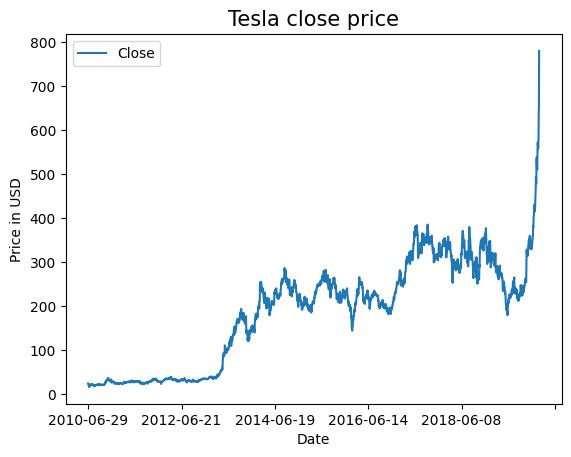

In [6]:
plt.figure(figsize=(15,5))
df.plot(x='Date',y='Close')
plt.title('Tesla close price',fontsize=15)
plt.xlabel("Date")
plt.ylabel("Price in USD")
plt.show()

In [7]:
df[df['Close']==df['Adj Close']].shape

(2416, 7)

Here we see that the columns named close and Adj Close contain the same data. Thus we can drop the Adj Close column as it is just redundant data.

In [8]:
df=df.drop(['Adj Close'],axis=1)

Distribution plot for the continuous features of the data set

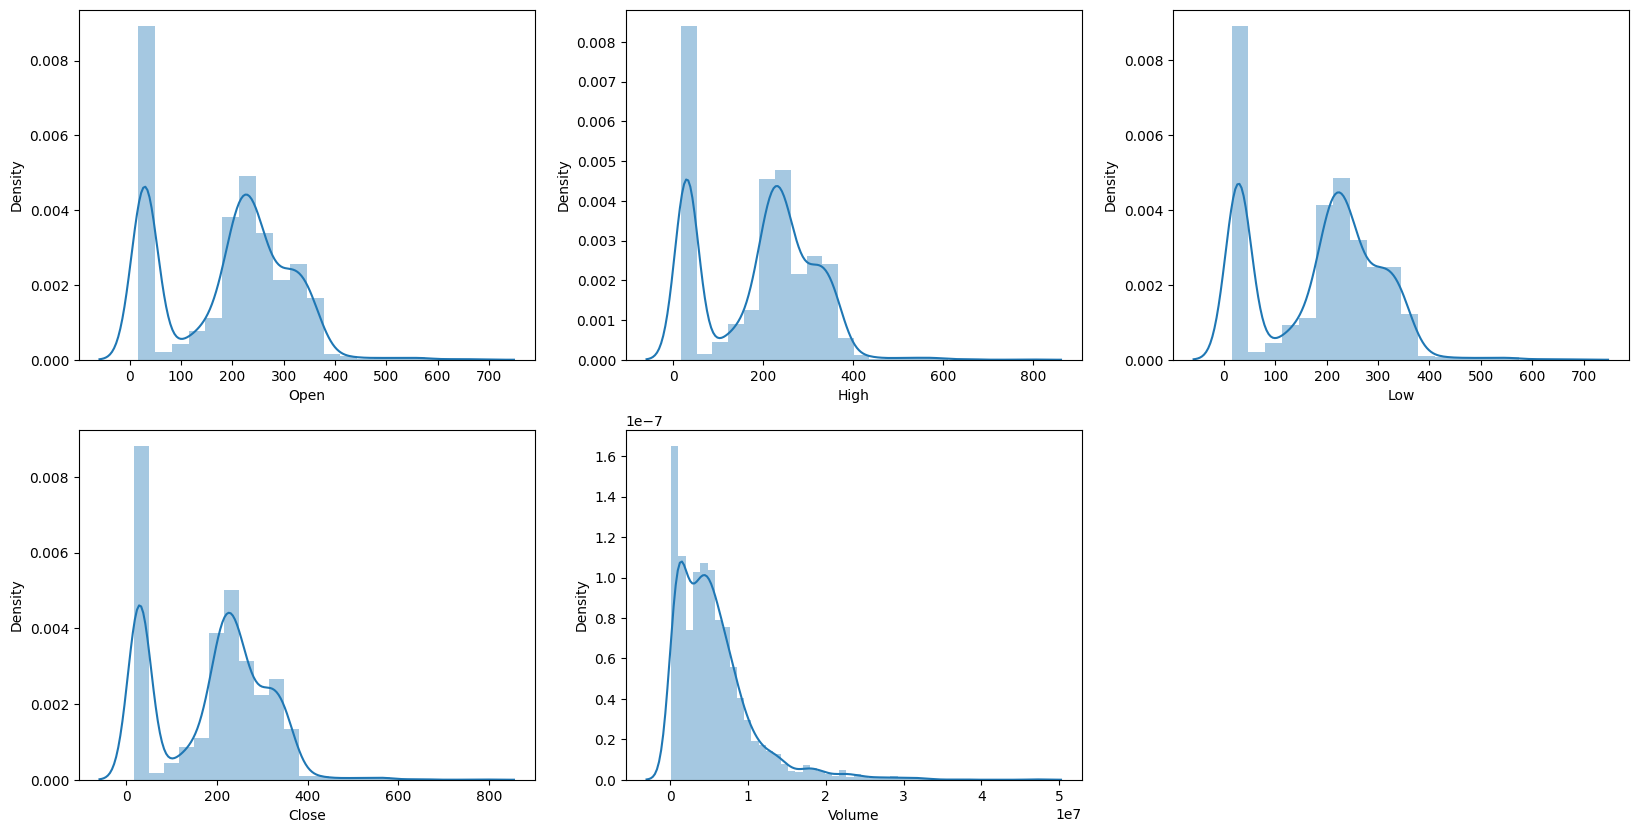

In [9]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
    plt.subplot(2,3,i+1)
    sb.distplot(df[col])
plt.show()

In the distribution plot of OHLC data, we can see two peaks which means the data has varied significantly in two regions. And the Volume data is left-skewed.

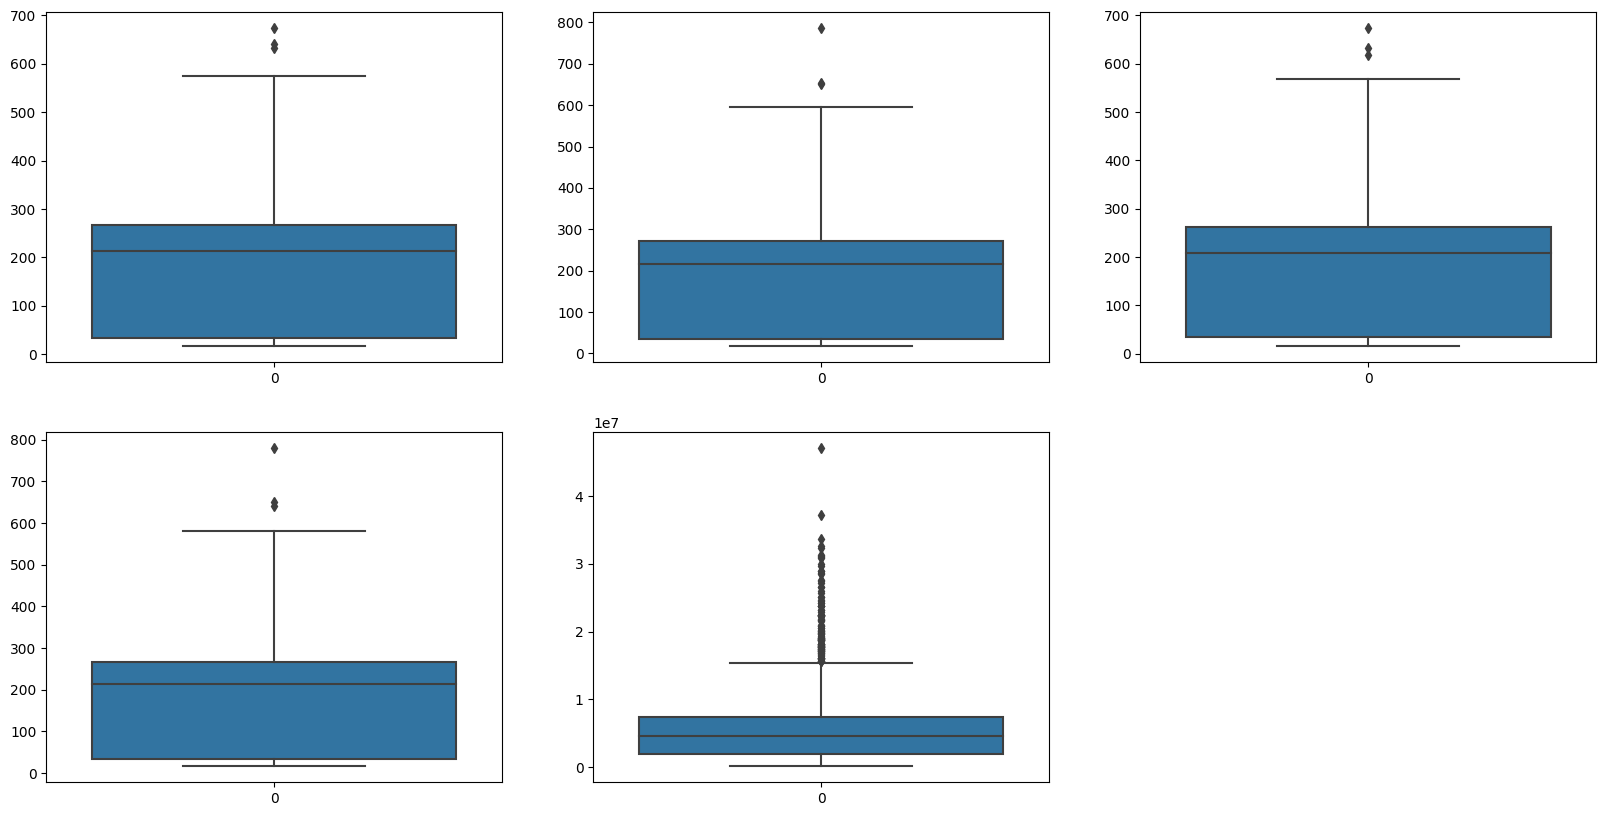

In [10]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
    plt.subplot(2,3,i+1)
    sb.boxplot(df[col])
plt.show()

We see that volume has some sort if outliers. All the other columns are free from outliers.

Now we perform feature engineering to extract more useful features from the already existing data.

In [11]:
splitted=df['Date'].str.split('-',expand=True)
df['Day']=splitted[2].astype(int)
df['Month']=splitted[1].astype(int)
df['Year']=splitted[0].astype(int)

df.head()

,Date,Open,High,Low,Close,Volume,Day,Month,Year
0,2010-06-29,19.000000,25.00,17.540001,23.889999,18766300,29,6,2010
1,2010-06-30,25.790001,30.42,23.299999,23.830000,17187100,30,6,2010
2,2010-07-01,25.000000,25.92,20.270000,21.959999,8218800,1,7,2010
3,2010-07-02,23.000000,23.10,18.709999,19.200001,5139800,2,7,2010
4,2010-07-06,20.000000,20.00,15.830000,16.110001,6866900,6,7,2010


In the above code we split the date column into three parts namely day, month and year.

In [12]:
df['is_quarter_end']=np.where(df['Month']%3==0,1,0)

In [20]:
df=df.drop(['Date'],axis=1)

A quarter is defined as a group of three months. Every company prepares its quarterly results and publishes them publicly so, that people can analyze the company’s performance. These quarterly results affect the stock prices heavily which is why we have added this feature because this can be a helpful feature for the learning model.

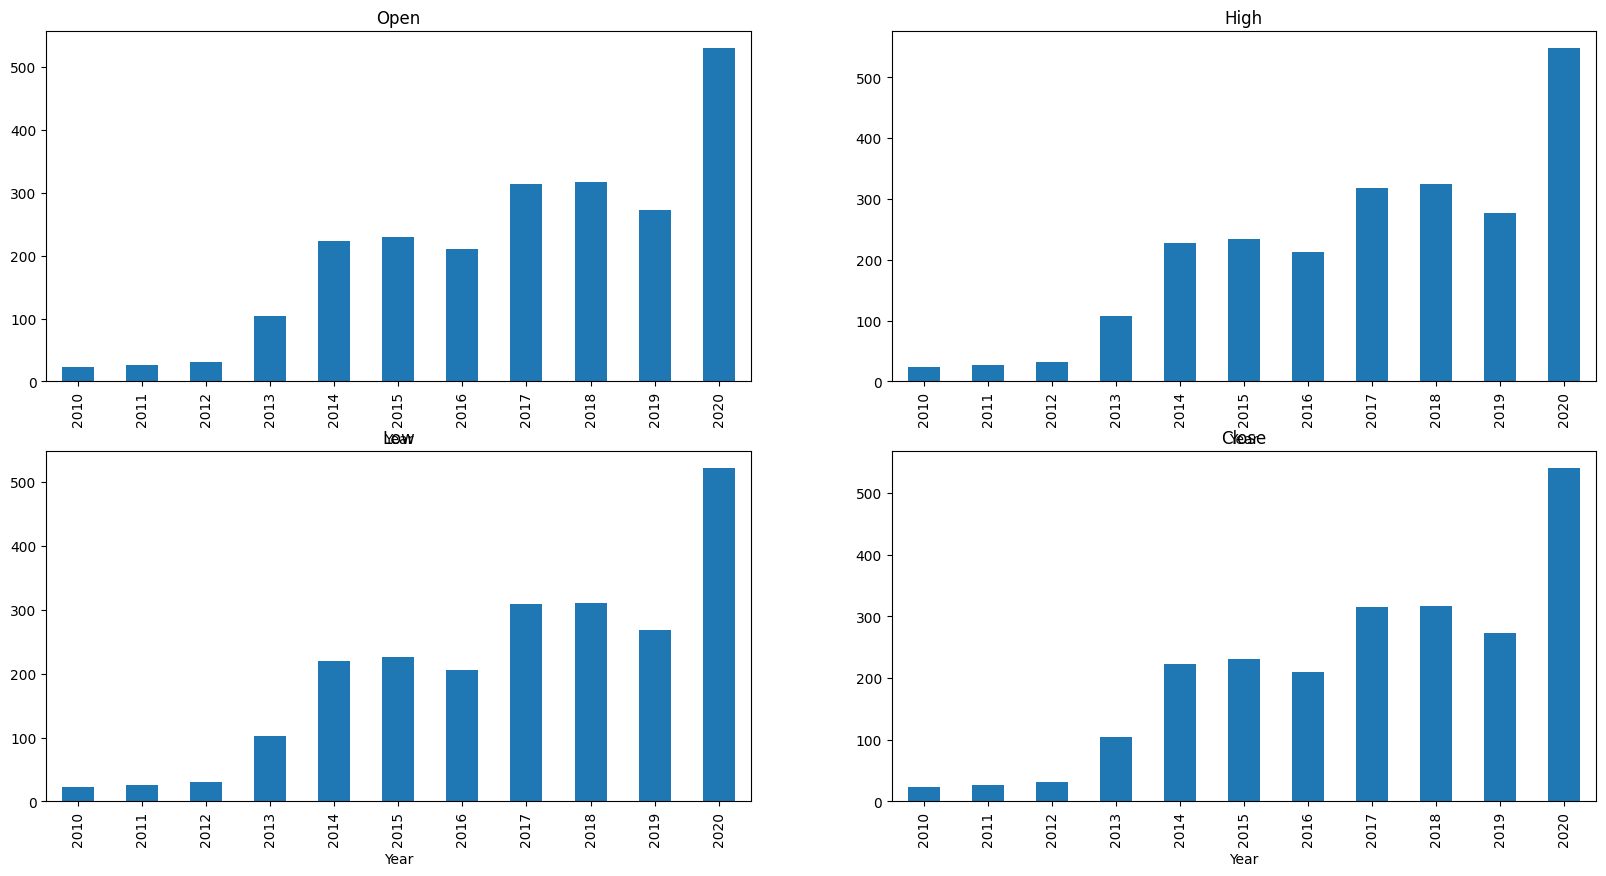

In [27]:
data_grouped = df.groupby('Year').mean()
plt.subplots(figsize=(20,10))

for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2,2,i+1)
    plt.title(col)
    data_grouped[col].plot.bar()
plt.show()

From the above bar graphs we can conclude that the stock prices from tesla have almost doubled from 2013 to 2014.

In [28]:
df.groupby('is_quarter_end').mean()

,Open,High,Low,Close,Volume,Day,Month,Year,open-close,low-high,target
is_quarter_end,,,,,,,,,,,
0,185.875081,189.254226,182.449499,186.085081,5.767062e+06,15.710396,6.173886,2014.816213,-0.210000,-6.804728,0.501856
1,187.071200,190.232700,183.860262,187.047163,5.180154e+06,15.825000,7.597500,2014.697500,0.024037,-6.372438,0.530000


Some observations from the above grouped data

1. Prices are higher during the months that are the quarter end as compared to those that are non quarter end months.
2. The volume of trade is lesser during the months that are quarter end.    

In [21]:
df['open-close']=df['Open']-df['Close']
df['low-high']=df['Low']-df['High']
df['target']=np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

Above we have added some more columns which will help in the training of our model. We have added the target feature which is a signal whether to buy or not we will train our model to predict this only. But before proceeding let’s check whether the target is balanced or not using a pie chart.

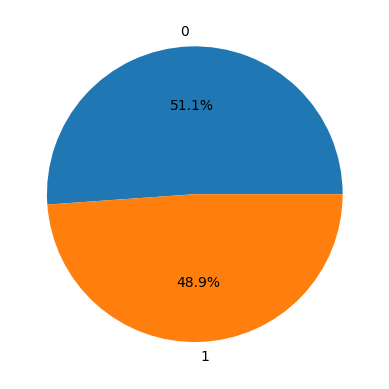

In [22]:
plt.pie(df['target'].value_counts().values,
		labels=[0, 1], autopct='%1.1f%%')
plt.show()

When we add features to our dataset we have to ensure that there are no highly correlated features as they do not help in the learning process of the algorithm.

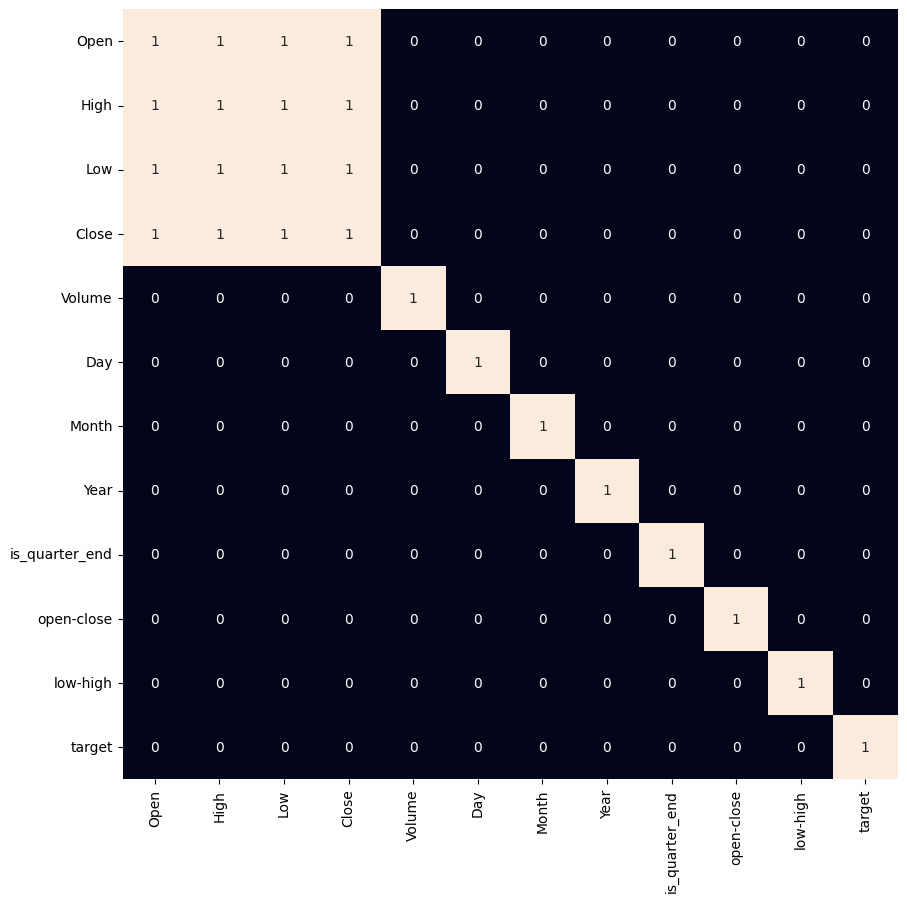

In [23]:
plt.figure(figsize=(10, 10))
# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sb.heatmap(df.corr() > 0.9, annot=True, cbar=False)
plt.show()

From the above heatmap we can conclude that the open, close, high and low values are highly correlated but the features we added like open-close, low-high and target are highly uncorrelated. 

Data normalization and splitting

In [29]:
features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_valid, Y_train, Y_valid = train_test_split(
	features, target, test_size=0.1, random_state=2022)
print(X_train.shape, X_valid.shape)

(2174, 3) (242, 3)


In the above code we are normalizing the data and then splitting the given data into a test and validation data set. Normalised data leads to a faster training of the model.

Model Development and Evaluation

In this project we are going to train the following models and evaulate them using the ROC-AUC curve(Reciver Operating Characteristics - Area Under Curve).

    1. Logistic Regression

    2. Support Vector Machine
    
    3. XGB Classifier

We use the ROC-AUC Curve because instead of predicting a hard probability of 0 or 1 we would like to predict soft probabilities between 0 and 1. This helps us measure the accuracy of the predictions.

In [31]:
models=[LogisticRegression(),SVC(kernel='poly',probability=True),XGBClassifier()]

for i in range(3):
    models[i].fit(X_train,Y_train)
    print(f'{models[i]} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(
    Y_train, models[i].predict_proba(X_train)[:,1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(
    Y_valid, models[i].predict_proba(X_valid)[:,1]))
    print()

LogisticRegression() : 
Training Accuracy :  0.5228802330060918
Validation Accuracy :  0.4923371647509579

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.5294364927164429
Validation Accuracy :  0.46257525998905313

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) : 
Training Accur

We see that the XGB classifier has the highest training accuracy of around 96% but has a validation accuracy of only 41%. This means that the XGB classifier is pruned to overfitting. For logistic regression however we see that the training and validation accuracy have almost similar values. 

Conclusion

We observe that the prediction of the above model is no better that guessing 50%. Possible reasons for this may be due to the lack of data or using a very simple model to perform such a complex task.